In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob
import cv2
import scipy
from keras.layers import Dense, Dropout, Activation, Flatten,GaussianDropout,AlphaDropout
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.models import Sequential
import numpy as np
import keras
from keras.utils import np_utils
from keras.regularizers import l2
# import cPickle
import numpy
import csv
import scipy.misc
import scipy
from scipy import ndimage
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import h5py

Using TensorFlow backend.


In [2]:
def load_data_for_vgg16():

    train_x = []
    train_y = []
    val_x =[]
    val_y =[]

    exclude=[]
    for line in open('../dlib/python_examples/fer2013_excluded.txt'):
        row=line.split('.')
        exclude.append(int(row[0]))
    count_labels=[0]*7
    count=0
    for line in open('fer2013.csv'):   
        row = line.split(',')
        if count not in exclude:
            try:
                train_y.append(int(row[0]))
                image=[int(p) for p in row[1].split()]
                image=np.reshape(image,(48,48))
                temp=np.expand_dims(image,2)
                image=np.concatenate((temp,temp),axis=2)
                image=np.concatenate((image,temp),axis=2)
                train_x.append(image)
                if int(row[0])==0:
                    count_labels[0]=count_labels[0]+1
                elif int(row[0])==1:
                    count_labels[1]=count_labels[1]+1
                elif int(row[0])==2:
                    count_labels[2]=count_labels[2]+1
                elif int(row[0])==3:
                    count_labels[3]=count_labels[3]+1
                elif int(row[0])==4:
                    count_labels[4]=count_labels[4]+1
                elif int(row[0])==5:
                    count_labels[5]=count_labels[5]+1
                elif int(row[0])==6:
                    count_labels[6]=count_labels[6]+1
            except ValueError:
                pass      # or whatever
        count=count+1
        
    train_x, train_y = np.array(train_x)/255.0, np.array(train_y)
    print(train_x.shape)
    print(train_y.shape)
    print(count_labels)
    weights={}
    for index,c in enumerate(count_labels):
        weights[index]=(np.sum(np.array(count_labels))-c)/np.sum(np.array(count_labels))
    print(weights)
    
    val_x, val_y = train_x[-1000:], train_y[-1000:]
    train_x, train_y = train_x[:-1000], train_y[:-1000]
    return train_x, train_y, val_x, val_y,weights

In [3]:
img_rows, img_cols = 48, 48
batch_size = 128
nb_classes = 7
nb_epoch = 1200
img_channels = 1

Train_x, Train_y, Val_x, Val_y ,weights= load_data_for_vgg16()
# Train_x=load_faces()

Train_x = Train_x.astype('float32')
Val_x = Val_x.astype('float32')

Train_y = np_utils.to_categorical(Train_y, nb_classes)
Val_y = np_utils.to_categorical(Val_y, nb_classes)

(26117, 48, 48, 3)
(26117,)
[3573, 439, 3353, 7240, 3596, 3092, 4824]
{0: 0.8631925565723475, 1: 0.9831910250028717, 2: 0.87161618868935942, 3: 0.72278592487651716, 4: 0.86231190412375081, 5: 0.8816096795190872, 6: 0.81529272121606622}


In [4]:
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.engine import Input
from keras.layers import GlobalAveragePooling2D, Dense, Reshape, Lambda, K, LSTM,Merge
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

import time
import numpy as np

np.random.seed(1337)


class CustomImageDataGenerator(ImageDataGenerator):
    
def rgb_to_grayscale(input):
    """Average out each pixel across its 3 RGB layers resulting in a grayscale image"""
    return K.mean(input, axis=3)


def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]



img_width = 48
img_height = 48

# CNN
model1=Sequential()
cnn_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(48,48,3))
model1.add(cnn_model)
model1.add(GlobalAveragePooling2D())


# LSTM
model2=Sequential()
model2.add(Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape,input_shape=(img_width, img_height, 3)))
model2.add(Reshape((48, 48)))
model2.add(LSTM(100, return_sequences=True))
model2.add(LSTM(100))

final_model=Sequential()
final_model.add(Merge([model1,model2], mode='concat'))
final_model.add(Dense(7, activation='softmax',kernel_regularizer=keras.regularizers.l2(0.01)))

print("Model built")

sgd=keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=False)
final_model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])

print("Starting training")
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="./vgg16_lstm_.hdf5", verbose=1, save_best_only=True,save_weights_only=True)
final_model.fit([Train_x,Train_x],Train_y, batch_size=32,epochs=50,validation_data=([Val_x,Val_x],Val_y),shuffle=True,verbose=1,
               class_weight=weights,callbacks=[earlyStopping,checkpointer],)

Building model...


/home/Shr147896325/anaconda3/envs/gym/lib/python3.5/site-packages/ipykernel_launcher.py:104: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Model built
Starting training
Train on 25117 samples, validate on 1000 samples
Epoch 1/50
25117/25117 [==============================] - 1613s - loss: 1.2280 - acc: 0.4961 - val_loss: 1.2375 - val_acc: 0.5720
Epoch 2/50
25117/25117 [==============================] - 1515s - loss: 0.9987 - acc: 0.5957 - val_loss: 1.2093 - val_acc: 0.5770
Epoch 3/50
25117/25117 [==============================] - 1513s - loss: 0.8936 - acc: 0.6326 - val_loss: 1.0464 - val_acc: 0.6280
Epoch 4/50
25117/25117 [==============================] - 1516s - loss: 0.8132 - acc: 0.6626 - val_loss: 1.0631 - val_acc: 0.6340
Epoch 5/50
25117/25117 [==============================] - 1514s - loss: 0.7334 - acc: 0.6939 - val_loss: 1.0253 - val_acc: 0.6430
Epoch 6/50
25117/25117 [==============================] - 1509s - loss: 0.6690 - acc: 0.7231 - val_loss: 0.9457 - val_acc: 0.6610
Epoch 7/50
25117/25117 [==============================] - 1516s - loss: 0.5999 - acc: 0.7535 - val_loss: 1.0210 - val_acc: 0.6720
Epoch 8/50


In [5]:
file = open('vgg16_lstm_.txt','w')  
file.write(final_model.to_yaml())
file.close()

In [4]:
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten,GaussianDropout,AlphaDropout
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_yaml
import numpy as np
import keras
from keras.utils import np_utils
from keras.regularizers import l2
# import cPickle
import numpy
import csv
import time
import scipy.misc
import scipy
from scipy import ndimage
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import h5py
file = open('models/vgg16_lstm_.txt', 'r') 
yaml_string=file.read() 
file.close()
model = model_from_yaml(yaml_string)
model.load_weights('models/vgg16_lstm_.hdf5')

sgd=keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])

/home/Shr147896325/anaconda3/envs/gym/lib/python3.5/site-packages/keras/engine/topology.py:1252: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


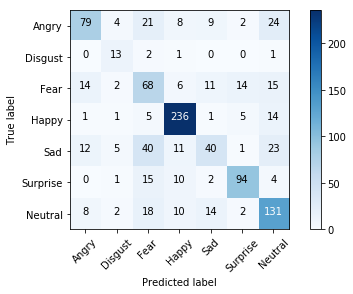

1000/1000 [==============================] - 16s    
[0.94565740871429438, 0.66100000000000003]


In [32]:
import itertools
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(np.argmax(Val_y,axis=1), np.argmax(model.predict([Val_x,Val_x]),axis=1),labels=[0,1,2,3,4,5,6])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Angry', 'Disgust', 'Fear', 'Happy','Sad','Surprise','Neutral'],
                        title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['Angry', 'Disgust', 'Fear', 'Happy','Sad','Surprise','Neutral'], normalize=True,
#                       title='Normalized confusion matrix')
# plt.savefig('../../../mnt/c/Users/roohis1/Downloads/New folder (2)/results/cm.png',bbox_inches = 'tight')
plt.show()
print(model.evaluate([Val_x,Val_x], Val_y))